## C 4.5 - Decision Tree



In [1]:
# Import requires packages and libraries
import csv 
import collections
import numpy as np
import pandas as pd
from math import log
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

##### Define Required Functions 

In [2]:
def loadData(file):
    def convertTypes(s):
        s = s.strip()
        try:
            return float(s) if '.' in s else int(s)
        except ValueError:
            return s

    reader = csv.reader(open(file, 'rt'))
    return [[convertTypes(item) for item in row] for row in reader]


def divideSet(rows, column, value):
    splittingFunction = None
    if isinstance(value, int) or isinstance(value, float): 
        splittingFunction = lambda row : row[column] >= value
    else: 
        splittingFunction = lambda row : row[column] == value
    list1 = [row for row in rows if splittingFunction(row)]
    list2 = [row for row in rows if not splittingFunction(row)]
    return (list1, list2)


def uniqueCounts(rows):
    results = {}
    for row in rows:
        r = row[-1]
        if r not in results: results[r] = 0
        results[r] += 1
    return results


def entropy(rows):
    log2 = lambda x: log(x)/log(2)
    results = uniqueCounts(rows)
    entr = 0.0
    
    for r in results:
        p = float(results[r])/len(rows)
        entr -= p*log2(p)
    return entr


def gini(rows):
    total = len(rows)
    counts = uniqueCounts(rows)
    imp = 0.0

    for k1 in counts:
        p1 = float(counts[k1])/total  
        for k2 in counts:
            if k1 == k2: continue
            p2 = float(counts[k2])/total
            imp += p1*p2
    return imp


def variance(rows):
    if len(rows) == 0: return 0
    data = [float(row[len(row) - 1]) for row in rows]
    mean = sum(data) / len(data)
    variance = sum([(d-mean)**2 for d in data]) / len(data)
    return variance

##### Create Decision Tree classes with true and false branches

In [3]:
class DecisionTree:
    def __init__(self, col=-1, value=None, trueBranch=None, falseBranch=None, results=None):
        self.col = col
        self.value = value
        self.trueBranch = trueBranch
        self.falseBranch = falseBranch
        self.results = results 

##### Grows and returns binary decision tree using gain - entropy or gini

In [4]:
def growDecisionTreeFrom(rows, evaluationFunction=entropy): 
    if len(rows) == 0: return DecisionTree()
    currentScore = evaluationFunction(rows)

    bestGain = 0.0
    bestAttribute = None
    bestSets = None

    columnCount = len(rows[0]) - 1 
    for col in range(0, columnCount):
        columnValues = [row[col] for row in rows]

        for value in columnValues:
            (set1, set2) = divideSet(rows, col, value)
            p = float(len(set1)) / len(rows)
            gain = currentScore - p*evaluationFunction(set1) - (1-p)*evaluationFunction(set2)
            if gain>bestGain and len(set1)>0 and len(set2)>0:
                bestGain = gain
                bestAttribute = (col, value)
                bestSets = (set1, set2)

    if bestGain > 0:
        trueBranch = growDecisionTreeFrom(bestSets[0])
        falseBranch = growDecisionTreeFrom(bestSets[1])
        return DecisionTree(col=bestAttribute[0], value=bestAttribute[1], trueBranch=trueBranch, falseBranch=falseBranch)
    else:
        return DecisionTree(results=uniqueCounts(rows))

##### Leveage minimal gain to prunes the tree

In [5]:
def prune(tree, minGain, evaluationFunction=entropy, notify=False):
    # branch with recursive call
    if tree.trueBranch.results == None: prune(tree.trueBranch, minGain, evaluationFunction, notify)
    if tree.falseBranch.results == None: prune(tree.falseBranch, minGain, evaluationFunction, notify)

    # merge leafs 
    if tree.trueBranch.results != None and tree.falseBranch.results != None:
        tb, fb = [], []

        for v, c in tree.trueBranch.results.items(): tb += [[v]] * c
        for v, c in tree.falseBranch.results.items(): fb += [[v]] * c

        p = float(len(tb)) / len(tb + fb)
        delta = evaluationFunction(tb+fb) - p*evaluationFunction(tb) - (1-p)*evaluationFunction(fb)
        if delta < minGain:	
            if notify: print('A branch was pruned: gain = %f' % delta)		
            tree.trueBranch, tree.falseBranch = None, None
            tree.results = uniqueCounts(tb + fb)

##### Define function to classify the observationss according to the tree

In [6]:
def classify(observations, tree, dataMissing=False):
 
    def classifyWithoutMissingData(observations, tree):
        if tree.results != None: 
            return tree.results
        else:
            v = observations[tree.col]
            branch = None
            if isinstance(v, int) or isinstance(v, float):
                if v >= tree.value: branch = tree.trueBranch
                else: branch = tree.falseBranch
            else:
                if v == tree.value: branch = tree.trueBranch
                else: branch = tree.falseBranch
        return classifyWithoutMissingData(observations, branch)


    def classifyWithMissingData(observations, tree):
        if tree.results != None: 
            return tree.results
        else:
            v = observations[tree.col]
            if v == None:
                tr = classifyWithMissingData(observations, tree.trueBranch)
                fr = classifyWithMissingData(observations, tree.falseBranch)
                tcount = sum(tr.values())
                fcount = sum(fr.values())
                tw = float(tcount)/(tcount + fcount)
                fw = float(fcount)/(tcount + fcount)
                result = collections.defaultdict(int)
                for k, v in tr.items(): result[k] += v*tw
                for k, v in fr.items(): result[k] += v*fw
                return dict(result)
            else:
                branch = None
                if isinstance(v, int) or isinstance(v, float):
                    if v >= tree.value: branch = tree.trueBranch
                    else: branch = tree.falseBranch
                else:
                    if v == tree.value: branch = tree.trueBranch
                    else: branch = tree.falseBranch
            return classifyWithMissingData(observations, branch)

    if dataMissing: 
        return classifyWithMissingData(observations, tree)
    else: 
        return classifyWithoutMissingData(observations, tree)

##### Function to plot the obtained Decision Tree

In [7]:
def plot(decision_Tree):
    def toString(decision_Tree, indent=''):
        if decision_Tree.results != None:  
            return str(decision_Tree.results)
        else:
            if isinstance(decision_Tree.value, int) or isinstance(decision_Tree.value, float):
                decision = 'Column %s: x >= %s?' % (decision_Tree.col, decision_Tree.value)
            else:
                decision = 'Column %s: x == %s?' % (decision_Tree.col, decision_Tree.value)
            trueBranch = indent + 'yes -> ' + toString(decision_Tree.trueBranch, indent + '\t\t')
            falseBranch = indent + 'no  -> ' + toString(decision_Tree.falseBranch, indent + '\t\t')
            return (decision + '\n' + trueBranch + '\n' + falseBranch)

    print(toString(decision_Tree))

##### Load, formate, and split the data into training set (70%), validation set (10%) and test set (20%)

In [8]:
data_train = loadData("/u/mreza6/5825/Data/adult.csv")
print(data_train[0])

df = pd.DataFrame(data_train)
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df['income_n'] = pd.factorize(df['income'])[0]

df = df.drop(['income'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df.drop(['income_n'], axis=1), df['income_n'], test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

tain_x = X_train
tain_x['income_n'] = y_train
g_dt = tain_x.values.tolist()
print(tain_x)

['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']
0     age     workclass  fnlwgt     education education.num  \
15549  84             ?  368925       5th-6th             3   
27817  37       Private  222450       5th-6th             3   
26001  20       Private  197997  Some-college            10   
29827  47       Private  583755       HS-grad             9   
11927  34       Private  116677  Some-college            10   
...    ..           ...     ...           ...           ...   
21169  64             ?  211360       HS-grad             9   
6453   32  Self-emp-inc  110331       HS-grad             9   
31353  47       Private   57534  Some-college            10   
6576   42       Private  153132     Bachelors            13   
23609  37       Private   98776       HS-grad             9   

0          marital.status         occupat

##### Grow the Decision Tree from training set

In [9]:
decision_Tree = growDecisionTreeFrom(g_dt)

##### Run the algorithm on the training set to learn a decision tree using the cut-off values = 0:2; 0:4; 0:6; 0:8

In [10]:
cut_Err = []
cut_off = [0.2,0.4,0.6,0.8]
for i in cut_off:
    prune(decision_Tree, i, notify=True)
    err = 0
    for ind in range(X_val.shape[0]):       
        m = False
        for j in range(X_val.shape[1]):
            v = str(X_val._get_value(ind, j, takeable = True))
            if v=='?':
                m = True
                break

        inst = X_val.iloc[ind].values.flatten().tolist()
        s = str(classify(inst, decision_Tree, dataMissing=m))
        if s[1]!=str(y_val.iloc[ind]):
            err+=1
    print("Cut-off value",i,"has",err/X_val.shape[0], "Error")
    cut_Err.append(err/X_val.shape[0])

A branch was pruned: gain = 0.032600
A branch was pruned: gain = 0.116115
A branch was pruned: gain = 0.007914
A branch was pruned: gain = 0.070012
A branch was pruned: gain = 0.080136
Cut-off value 0.2 has 0.20690978886756237 Error
A branch was pruned: gain = 0.391244
A branch was pruned: gain = 0.258019
A branch was pruned: gain = 0.297472
A branch was pruned: gain = 0.371232
A branch was pruned: gain = 0.337290
A branch was pruned: gain = 0.391244
A branch was pruned: gain = 0.337290
A branch was pruned: gain = 0.371232
A branch was pruned: gain = 0.371232
A branch was pruned: gain = 0.276195
A branch was pruned: gain = 0.337290
A branch was pruned: gain = 0.205110
A branch was pruned: gain = 0.228538
A branch was pruned: gain = 0.322757
A branch was pruned: gain = 0.322757
A branch was pruned: gain = 0.391244
A branch was pruned: gain = 0.020714
A branch was pruned: gain = 0.337290
A branch was pruned: gain = 0.391244
A branch was pruned: gain = 0.276195
A branch was pruned: gain =

##### Plot the training error for each cut-off

Training Errors: 
   Cut-Off     Error
0      0.2  0.206910
1      0.4  0.214012
2      0.6  0.219002
3      0.8  0.282917


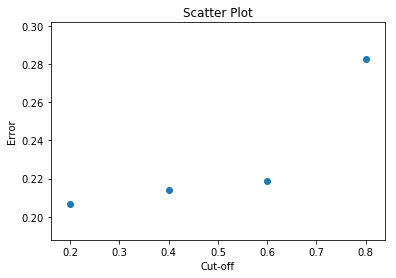

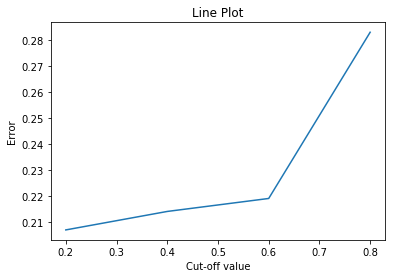

In [11]:
print("Training Errors:", "\n=================")
cut_Error = pd.DataFrame({"Cut-Off": cut_off, "Error": cut_Err})
print(cut_Error)

error_n = []
for i in range(4):
    error_n.append(cut_Err[i])
plt.title("Scatter Plot")
plt.scatter(cut_off,error_n)
plt.xlabel("Cut-off")
plt.ylabel("Error")
plt.show()

plt.title("Line Plot")
plt.plot(cut_off,error_n)
plt.xlabel("Cut-off value")
plt.ylabel("Error")
plt.show()

##### Test the decision trees on the test set

In [12]:
error_m = 0
for ind in range(X_test.shape[0]):
    
    m = False
    for j in range(X_test.shape[1]):
        v = str(X_test._get_value(ind, j, takeable = True))
        if v=='?':
            m = True
            break

    inst = X_test.iloc[ind].values.flatten().tolist()
     
    s = str(classify(inst, decision_Tree, dataMissing=m))
    if s[1]!=str(y_test.iloc[ind]):
        error_m+=1
    

print("Test error:",error_m/X_test.shape[0])
cut_Err.append(error_m/X_test.shape[0])

Test error: 0.27391371103945955


##### Plot test errors together with training errors for each trained tree

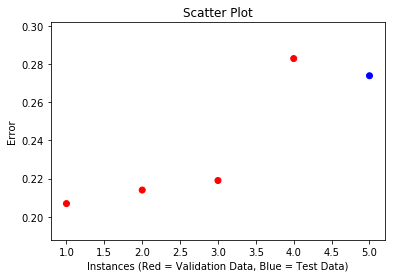

In [13]:
plt.title("Scatter Plot")
plt.scatter([1,2,3,4,5],cut_Err,color=['red','red','red','red','blue'])
plt.xlabel("Instances (Red = Validation Data, Blue = Test Data)")
plt.ylabel("Error")
plt.show()

### Conclusion:

##### C4.5 is an algorithm developed by Ross Quinlan used to generate the decision tree. It is an extension of Quinlan's earlier ID3 algorithm. C4.5 builds decision trees from a set of training data the same way as ID3, using the concept of information entropy, which is the measurement of the uncertainty in the dataset.

##### At each node of the tree, C4.5 chooses the data attributes that have the most effective split. The splitting criterion is nothing but the normalized information gain (difference in entropy). Then the attribute with the highest normalized information gain leveraged to make the decision. The C4.5 algorithm then recurs on the smaller sublists.

##### In addition to that, tree pruning reduces the depth of the tree, and Information gain measures the difference in entropy. The threshold is the calculated average of the sum of the positive and negative class values for the feature, which has the highest information gain.

##### Finally, the cut-off value 0.2 has the lowest error rate of 0.206910 with training data, and test data has an error rate of 0.273914. it also appeared that the Decision Tree performs well with such (adult-census-income) dataset, which may be because of the binary nature of the data, where the prediction is either '1' or '0'.